# Appendix: Testing with `autograd`

The `autograd` package allows automatic differentiation by building computational graphs on the fly every time we pass data through our model. Autograd tracks which data combined through which operations to produce the output. This allows us to take derivatives over ordinary imperative code. This functionality is consistent with the memory and time requirements outlined above for BP.

**Scalars.** Here we calculate $\mathsf{y} = \boldsymbol{\mathsf x}^\top \boldsymbol{\mathsf x} = \sum_i {\boldsymbol{\mathsf{x}}_i}^2$ where the initialized tensor $\boldsymbol{\mathsf{x}}$ initially has no gradient (i.e. `None`). Calling backward on $\mathsf{y}$ results in gradients being stored on the leaf tensor $\boldsymbol{\mathsf{x}}.$ Note that unlike our implementation, there is no need to set `y.grad = 1.0`. Moreover, doing so would result in an error as $\mathsf{y}$ is not a [leaf node](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html) in the graph.

In [1]:
import torch
import torch.nn.functional as F
print(torch.__version__)

2.2.2


In [2]:
x = torch.arange(4, dtype=torch.float, requires_grad=True)
print(x.grad)

y = x.reshape(1, -1) @ x 
y.backward() 
print((x.grad == 2*x).all().item())

None
True


<br>

**Vectors.** Let $\boldsymbol{\mathsf y} = g(\boldsymbol{\mathsf x})$ and let $\boldsymbol{{\mathsf v}}$ be a vector having the same length as $\boldsymbol{\mathsf y}.$ Then `y.backward(v)` calculates
$\sum_i {\boldsymbol{\mathsf v}}_i \frac{\partial {\boldsymbol{\mathsf y}}_i}{\partial {\boldsymbol{\mathsf x}}_j}$
resulting in a vector of same length as $\boldsymbol{\mathsf{x}}$ stored in `x.grad`. Note that the terms on the right are the local gradients. Setting ${\boldsymbol{\mathsf v}} = \frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf y}}$ gives us the vector $\frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf x}}.$ Below $\boldsymbol{\mathsf y}(\boldsymbol{\mathsf x}) = [x_0, x_1].$

In [3]:
x = torch.rand(size=(4,), dtype=torch.float, requires_grad=True)
v = torch.rand(size=(2,), dtype=torch.float)
y = x[:2]

# Computing the Jacobian by hand
J = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0]], dtype=torch.float
)

# Confirming the above formula
y.backward(v)
(x.grad == v @ J).all()

tensor(True)

**Remark.** Memory and compute is wasted for running code that should not involve backpropagation. Hence, we wrap this part our code in a `torch.no_grad()` context (or run it inside a function decorated with `@torch.no_grad()`) so that a computation graph is not built. 

A related method is `.detach()` used to return a tensor detached from the current graph. The result will therefore not require gradients. It is important to note that the detached tensor still shares the same storage with the original one, so that in-place modifications on either tensor takes effect for both and can result in subtle bugs.

## Testing

Finally, we write our tests with `autograd` to check the correctness of our implementation:

In [4]:
from chapter import *

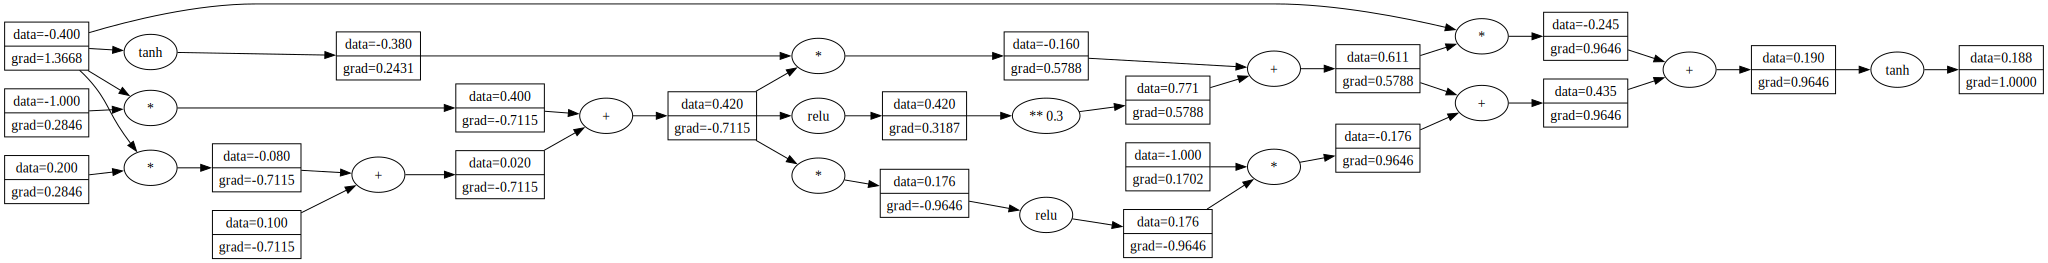

In [5]:
x = Node(-0.4)
z = Node(0.2) * x + Node(0.1) - x
q = z.relu() ** 0.3 + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()
y.backward()

x_node, y_node, z_node = x, y, z
draw_graph(y_node)

In [6]:
x = torch.tensor(-0.4, requires_grad=True)
z = 0.2 * x + 0.1 - x
q = z.relu() ** 0.3 + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()

z.retain_grad()
y.retain_grad()
y.backward()

x_torch, y_torch, z_torch = x, y, z

# forward
errors = []
errors.append(abs(x_node.data - x_torch.item()))
errors.append(abs(y_node.data - y_torch.item()))
errors.append(abs(z_node.data - z_torch.item()))

# backward
errors.append(abs(x_node.grad - x_torch.grad.item()))
errors.append(abs(y_node.grad - y_torch.grad.item()))
errors.append(abs(z_node.grad - z_torch.grad.item()))

print(f"Max absolute error: {max(errors):.2e}")

Max absolute error: 3.51e-08
